In [1]:
# Standard libraries
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import os
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time

# Custom imports


from GEMS_TCO import kernels_reparam_space_time_gpu as kernels_reparam_space_time
from GEMS_TCO import orderings as _orderings 
from GEMS_TCO import alg_optimization, BaseLogger

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2, exact_location_filter
from GEMS_TCO import debiased_whittle
from torch.nn import Parameter

In [2]:
space: List[str] = ['1', '1']
lat_lon_resolution = [int(s) for s in space]
mm_cond_number: int = 8
years = ['2024']
#years = ['2025']
month_range = [7] 

output_path = input_path = Path(config.mac_estimates_day_path)
data_load_instance = load_data2(config.mac_data_load_path)

#lat_range_input = [1, 3]
#lon_range_input = [125.0, 129.0]

#lat_range_input=[0,5]      
#lon_range_input=[123, 133.0] 

lat_range_input=[-3,2]      
lon_range_input=[121, 131] 


df_map, ord_mm, nns_map = data_load_instance.load_maxmin_ordered_data_bymonthyear(
lat_lon_resolution=lat_lon_resolution, 
mm_cond_number=mm_cond_number,
years_=years, 
months_=month_range,

lat_range=lat_range_input,   
lon_range=lon_range_input

)

In [3]:
daily_aggregated_tensors_dw = [] 
daily_hourly_maps_dw = []      

daily_aggregated_tensors_vecc = [] 
daily_hourly_maps_vecc = []   


for day_index in range(31):
    hour_start_index = day_index * 8
    
    hour_end_index = (day_index + 1) * 8
    #hour_end_index = day_index*8 + 1
    hour_indices = [hour_start_index, hour_end_index]

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= None,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=True  #keep_exact_loc
    )

    daily_aggregated_tensors_dw.append( day_aggregated_tensor )
    daily_hourly_maps_dw.append( day_hourly_map )



In [ ]:
day = 1 

hour = 1
keys = list(daily_hourly_maps_dw[day].keys())
# 1. Get the specific tensor data
daily_hourly_maps_dw[day][keys[hour]][:200]



start below

--- Analysis for first 3 days ---


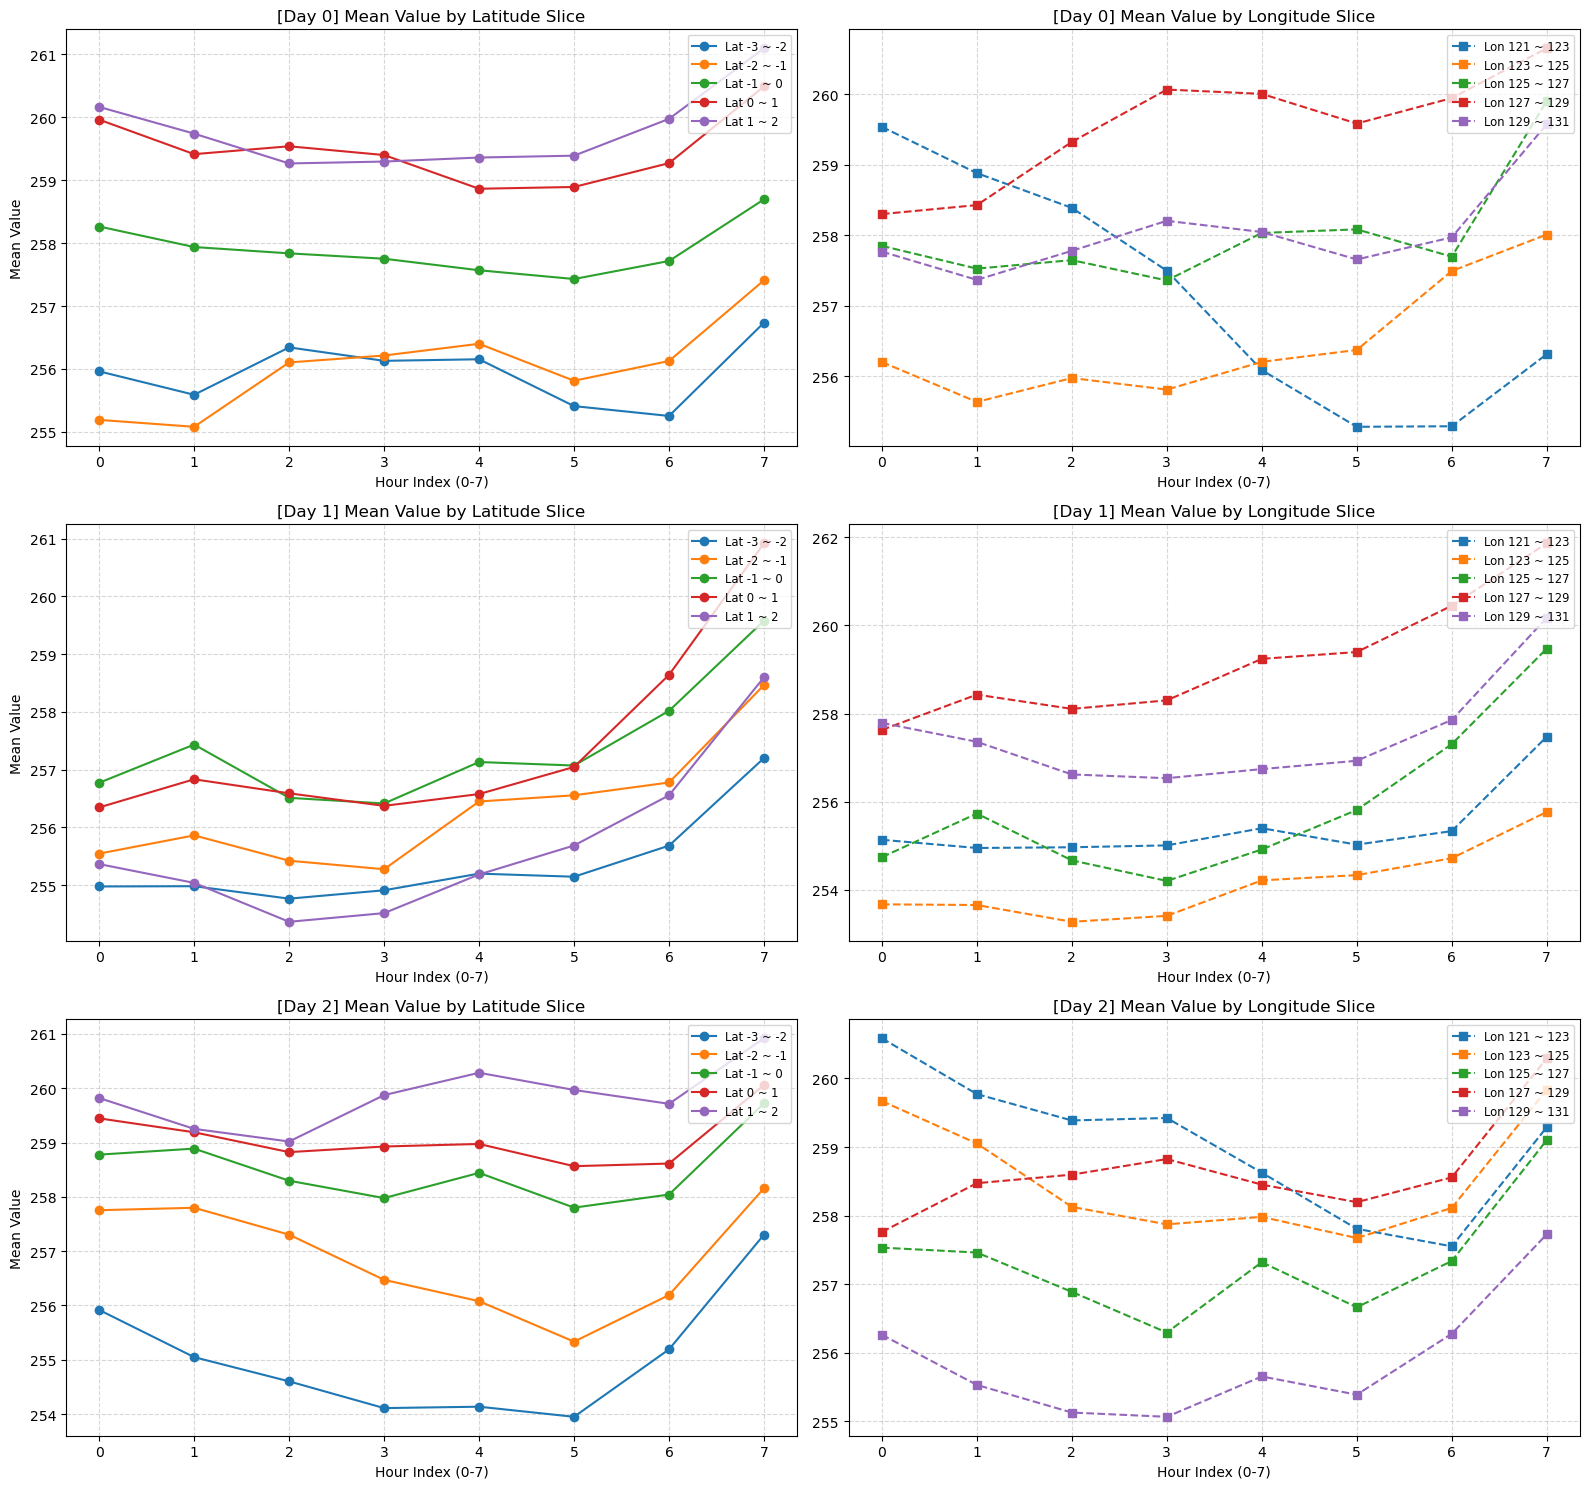

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def analyze_and_plot_slices(data_maps, days_to_check=3):
    # 3행 2열 그래프 생성 (행: 날짜, 열: Lat분석 / Lon분석)
    fig, axes = plt.subplots(days_to_check, 2, figsize=(16, 5 * days_to_check))
    
    # 1. Slice 구간 정의
    # Latitude: -3 to 2 (간격 1) -> 5개 구간: [-3, -2), [-2, -1), ...
    lat_bins = np.array([-3, -2, -1, 0, 1, 2])
    
    # Longitude: 121 to 131 (간격 2) -> 5개 구간: [121, 123), ...
    lon_bins = np.array([121, 123, 125, 127, 129, 131])
    
    # X축: 시간 인덱스 (0~7)
    hours_x = np.arange(8)

    print(f"--- Analysis for first {days_to_check} days ---")

    for day_idx in range(days_to_check):
        day_data = data_maps[day_idx]
        
        # [Key Sorting] 
        # 키가 정수(0,1,2...)라면 그냥 sorted()로 충분하지만,
        # 만약 문자열이 섞여있거나 순서가 보장되지 않을 경우를 대비해 안전하게 정렬
        try:
            sorted_keys = sorted(day_data.keys(), key=lambda x: int(x) if isinstance(x, (int, str)) and str(x).isdigit() else x)
        except:
            sorted_keys = sorted(day_data.keys())
            
        # 평균값 저장할 배열 (5개 슬라이스 x 8시간)
        # 초기값을 nan으로 채워 데이터가 없는 구간은 그래프가 끊기게 함
        lat_means = np.full((5, 8), np.nan)
        lon_means = np.full((5, 8), np.nan)
        
        for h_idx, key in enumerate(sorted_keys):
            if h_idx >= 8: break # 하루 8시간만 체크
            
            # 텐서 가져오기 및 numpy 변환
            tensor = day_data[key]
            if isinstance(tensor, torch.Tensor):
                data = tensor.detach().cpu().numpy() # detach 추가 (안전장치)
            else:
                data = tensor
            
            # Data Columns: [0:Lat, 1:Lon, 2:Value, 3:Time]
            lats = data[:, 0]
            lons = data[:, 1]
            vals = data[:, 2]
            
            # --- Latitude Slicing ---
            # np.digitize: 값이 bins[i-1] <= x < bins[i] 일 때 i 반환
            # 결과 인덱스: 1, 2, 3, 4, 5 -> (배열 인덱스 맞추기 위해 -1) -> 0, 1, 2, 3, 4
            lat_inds = np.digitize(lats, lat_bins) - 1
            for i in range(5):
                mask = lat_inds == i
                if np.any(mask):
                    lat_means[i, h_idx] = np.mean(vals[mask])
            
            # --- Longitude Slicing ---
            lon_inds = np.digitize(lons, lon_bins) - 1
            for i in range(5):
                mask = lon_inds == i
                if np.any(mask):
                    lon_means[i, h_idx] = np.mean(vals[mask])

        # --- 그래프 그리기 (Lat - Left Column) ---
        ax_lat = axes[day_idx, 0]
        for i in range(5):
            label = f"Lat {lat_bins[i]} ~ {lat_bins[i+1]}"
            # 데이터가 하나라도 있어야 그림
            if not np.all(np.isnan(lat_means[i])):
                ax_lat.plot(hours_x, lat_means[i], marker='o', label=label)
        
        ax_lat.set_title(f"[Day {day_idx}] Mean Value by Latitude Slice")
        ax_lat.set_xlabel("Hour Index (0-7)")
        ax_lat.set_ylabel("Mean Value")
        ax_lat.grid(True, linestyle='--', alpha=0.5)
        ax_lat.legend(fontsize='small', loc='upper right')

        # --- 그래프 그리기 (Lon - Right Column) ---
        ax_lon = axes[day_idx, 1]
        for i in range(5):
            label = f"Lon {lon_bins[i]} ~ {lon_bins[i+1]}"
            if not np.all(np.isnan(lon_means[i])):
                ax_lon.plot(hours_x, lon_means[i], marker='s', linestyle='--', label=label)
            
        ax_lon.set_title(f"[Day {day_idx}] Mean Value by Longitude Slice")
        ax_lon.set_xlabel("Hour Index (0-7)")
        ax_lon.grid(True, linestyle='--', alpha=0.5)
        ax_lon.legend(fontsize='small', loc='upper right')

    plt.tight_layout()
    plt.show()

# 실행
analyze_and_plot_slices(daily_hourly_maps_dw, days_to_check=3)

평행선(Parallel): 모든 위도/경도 슬라이스에서 값이 같이 오르고 같이 내린다면 -> Interaction 항 불필요 (단순 Time + Lat 효과).

교차/기울기 차이(Cross/Diverge): 위쪽 위도에서는 값이 오르는데 아래쪽에서는 내리거나, 변화 폭이 확연히 다르다면 -> Interaction 항(Lat*Time) 필수.